In [1]:
## Important libraries to import
# import math;         # math functions
# from math import pi as PI
# import os;           # miscellaneous operating system interfaces
import numpy as np;  # scientific computing with Python
#import scipy;       # scientific computing and technical computing (more tools like optimization)
import matplotlib.pyplot as plt;                        # plotting functions
# import numpy.polynomial.hermite_e as H
# import pandas as pd;
# import time
from scipy.stats import norm
# from scipy.stats import expon
# from scipy.stats import uniform

In [2]:
def get_mpdf(m, mmin, mmax, b):
    val1 = 10**(-b*(m-mmin))
    val2 = 10**(-b*(mmax-mmin))
    return np.asarray(b*np.log(10)*val1/(1-val2) if m > mmin and m < mmax else 0)

In [3]:
def get_rpdf(r, rmin, rmax, rchoice, lfault):
    if rchoice == 0: # Area source
        return np.asarray(r/5000 if r >= rmin and r <= rmax else 0)
    if rchoice == 1: # Line source
        return np.asarray(r/50/np.sqrt(r**2-lfault) if r > rmin and r <= rmax else 0)

In [4]:
def trap_int(x,t,y0):
    yArr = [0]*len(x)
    yArr[0] = y0
    for i in range(1,len(x)):
        yArr[i] = yArr[i-1] + 0.5*(x[i]+x[i-1])*(t[i]-t[i-1]) if x[i] > 0 else yArr[i-1]
    return np.asarray(yArr)

In [5]:
def binArea(x,y,nbin):
    ymarks = np.linspace(0,1,nbin+1)
    ymarks = np.delete(ymarks, [len(ymarks)-1,0])
    imarks = [next(j for j, k in enumerate(y) if k >= i) for i in ymarks]
    return x[imarks], ymarks, imarks

In [6]:
def genRandComb(nBin,nVar):
    comb = np.zeros((nBin, nVar))
    comb[0:,0] = np.random.permutation(np.arange(nBin))
    for i in range(1,nVar):
        for j in range(nBin):
            choice = np.arange(nBin)
            usedVal = np.unique(np.append(np.transpose(comb[j,0:i]),comb[0:j,i]))
            ind2del = [next(ii for ii, jj in enumerate(choice) if jj == kk) for kk in usedVal]
            choice2 = np.delete(choice,ind2del)
            comb[j,i] = np.random.permutation(choice2)[0]
    return comb

In [7]:
def getIM(combVal):
    return [-0.152 + 0.859*combVal[i,0] - 1.803*np.log(combVal[i,1]+25) for i in range(len(combVal))]

In [8]:
def getIMFull(m,r):
    return [-0.152 + 0.859*i - 1.803*np.log(j+25) for i in m for j in r]

In [9]:
def getStat(x):
    return np.mean(x), np.std(x,ddof=1)

In [10]:
mmin = 5
mmax = 8
b = 1
# rmin = 0
# rmax = 100
lfault = 100
lperp = 10
rmin = lperp
rmax = np.sqrt((lfault/2)**2+lperp**2)
rchoice = 1

In [11]:
### Var 1
dm = 0.001
npts = (mmax+0.25-(mmin-0.25))/dm+1
m = np.linspace(mmin-0.25,mmax+0.25,npts)
mpdf = np.asarray([get_mpdf(i,mmin,mmax,b) for i in m])
### Var 2
dr = 0.01
npts = (rmax+5-0)/dr+1
# r = np.linspace(-50,150,npts)
r = np.linspace(0,rmax+5,npts)
# rpdf = np.asarray([get_rpdf(i,rmin,rmax,rchoice,0) for i in r])
rpdf = np.asarray([get_rpdf(i,rmin,rmax,rchoice,lfault) for i in r])

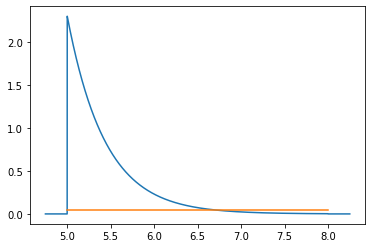

In [12]:
plt.figure()
plt.plot(m,mpdf)
plt.plot([5,8],[np.median(mpdf),np.median(mpdf)])
plt.show()

In [13]:
mcdf = trap_int(mpdf,m,0)
rcdf = trap_int(rpdf,r,0)

In [14]:
nVar = 2
nBinArr = [5,10,20,50,100,200]
lnIMOut = np.zeros((len(nBinArr)))
stdOut = np.zeros((len(nBinArr)))
for i in range(len(nBinArr)):
    mcdfBin = [0]
    imBin = [0]
    mpdfBin = [0]
    rBin = [0]
    rcdfBin = [0]
    irBin = [0]
    rpdfBin = [0]
    comb = [0]
    combVal = [0]
    x1 = [0]
    x2 = [0]
    combPGA = [0]
    ##
    nBin = nBinArr[i]
    ##
    mBin, mcdfBin, imBin = binArea(m,mcdf,nBin)
    mpdfBin = mpdf[imBin]
    rBin, rcdfBin, irBin = binArea(r,rcdf,nBin)
    rpdfBin = rpdf[irBin]
    ##
    comb = genRandComb(nBin,nVar)
    combVal = np.zeros((nBin,nVar))
    x1 = np.append(np.ones(1)*mmin,np.append(mBin,np.ones(1)*mmax))
    x2 = np.append(np.ones(1)*rmin,np.append(rBin,np.ones(1)*rmax))
    for j in range(nBin):
        combVal[j,0] = (x1[int(comb[j,0])] + x1[int(comb[j,0])+1])/2
        combVal[j,1] = (x2[int(comb[j,1])] + x2[int(comb[j,1])+1])/2
    ##
    combPGA = getIM(combVal)
    lnIMOut[i], stdOut[i] = getStat(combPGA)

In [15]:
### Var 1
dm = 0.05
npts = (mmax-mmin)/dm+1
mFull = np.linspace(mmin,mmax,npts)
### Var 2
dr = 0.1
npts = (rmax-rmin)/dr+1
rFull = np.linspace(rmin,rmax,npts)
##
##missing get probabilities

###
lnIM_Full = getIMFull(mFull,rFull)
medFull,stdFull = getStat(lnIM_Full)

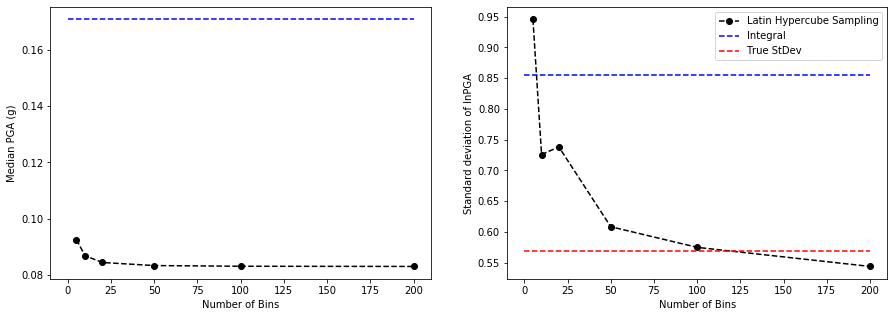

In [16]:
figl = 30;
figh = 5;

# Create figure handle
fig1, ax1 = plt.subplots(1,1,figsize=(figl/2,figh))
plt.subplot(1,2,1)
plt.plot(nBinArr,np.exp(lnIMOut),'--ok')
plt.plot([0,200],[np.exp(medFull),np.exp(medFull)],'--b')
plt.xlabel('Number of Bins')
plt.ylabel('Median PGA (g)')

plt.subplot(1,2,2)
plt.plot(nBinArr,stdOut,'--ok')
plt.plot([0,200],[stdFull,stdFull],'--b')
plt.plot([0,200],[0.57,0.57],'--r')
plt.xlabel('Number of Bins')
plt.ylabel('Standard deviation of lnPGA')
plt.legend(['Latin Hypercube Sampling','Integral','True StDev'])

plt.show()

In [17]:
dIM = 0.01
IMmin = 0.01
IMmax = 3
npts = (IMmax-IMmin)/dIM+1
IM = np.linspace(IMmin,IMmax,npts)
P_IM = np.asarray([1-norm.cdf(np.log(IM), loc=lnIMOut[i], scale=stdOut[i]) for i in range(len(lnIMOut))])
rate = 0.01
rate_IM = P_IM*rate

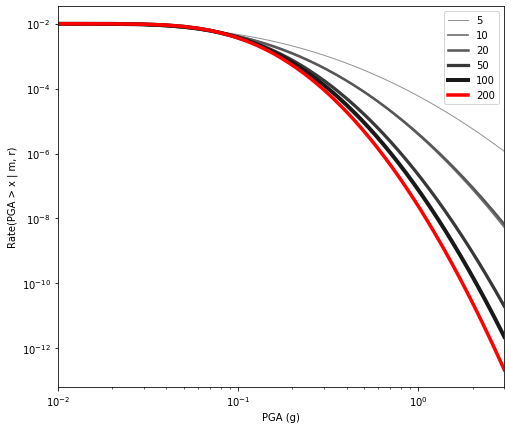

In [18]:
figl = 16
figh = 7

# Create figure handle
fig1, ax1 = plt.subplots(1,1,figsize=(figl/2,figh))
lw0 = 1
for i in range(len(rate_IM)):
    clr = 0.7-0.12*(i+1)
    if i < len(rate_IM)-1:
        plt.loglog(IM,rate_IM[i,:],'-',color=[clr,clr,clr],linewidth=lw0+0.75*i)
    else:
        plt.loglog(IM,rate_IM[i,:],'-r',linewidth=lw0+0.5*i)
plt.xlabel('PGA (g)')
plt.ylabel('Rate(PGA > x | m, r)')
plt.xlim((0.01,3))
plt.legend(nBinArr)

In [280]:
len(lnIM_Full)

2542

In [265]:
combVal.shape

(200, 2)

In [232]:
type(P_IM)

list